## load packages and data

In [3]:
library(dplyr)
library(data.table)
library(corrplot)
library(gridExtra)
library(readxl)
library(png)
options(warn=-1)
library(tidyverse)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

√ ggplot2 3.3.0     √ purrr   0.3.4
√ tibble  3.0.1     √ stringr 1.4.0
√ tidyr   1.0.2     √ forcats 0.5.0
√ readr   1.3.1     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x data.table::between() masks dplyr::between()
x gridExtra::combine()  masks dplyr::combine()
x dplyr::filter()       masks stats::filter()
x data.table::first()   masks dplyr::first()
x dplyr::lag()          masks stats::lag()
x data.table::last()    masks dplyr::last()
x purrr::transpose()    masks data.table::transpose()



In [4]:
setwd("C:/Users/dcng/Desktop/coronavirusdataset_20200430")
case <- read_csv("Case.csv",col_type=cols())
patient_info <- read_csv("PatientInfo.csv",col_type=cols())
patient_route <- read_csv("PatientRoute.csv",col_type=cols())
region <- read_csv("Region.csv",col_type=cols())
search_trend <- read_csv("SearchTrend.csv",col_type=cols())
seoul_floating <- read_csv("SeoulFloating.csv",col_type=cols())
time <- read_csv("Time.csv",col_type=cols())
time_age <- read_csv("TimeAge.csv",col_type=cols())
time_gender <- read_csv("TimeGender.csv",col_type=cols())
time_province <- read_csv("TimeProvince.csv",col_type=cols())
weather <- read_csv("Weather.csv",col_type=cols())

# 1. 데이터 전처리 & EDA

#### 연령대별 누적 확진자 분포

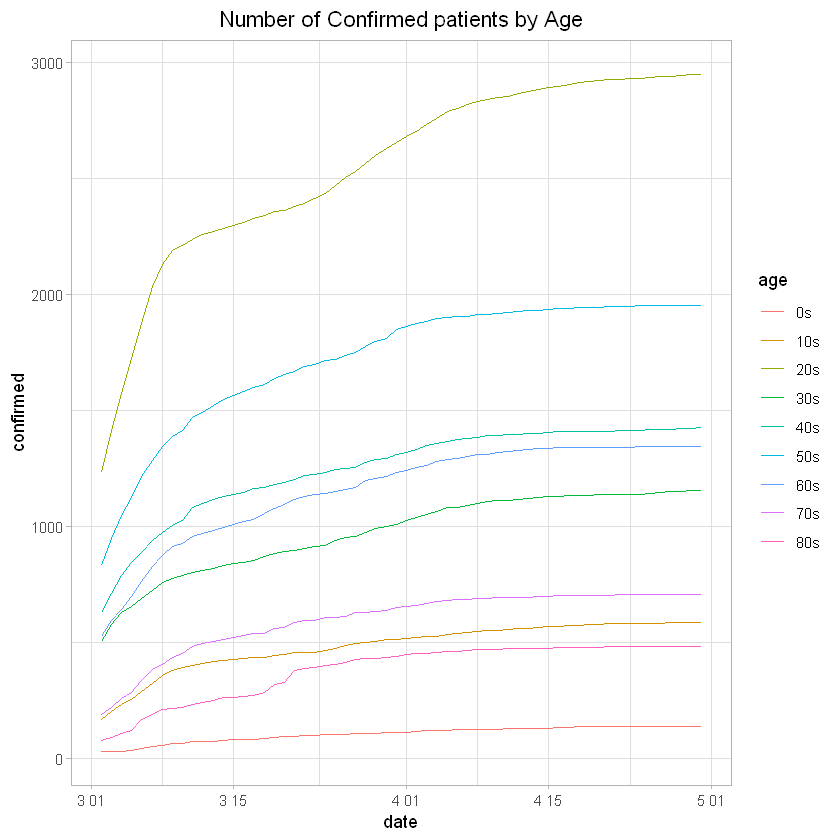

In [5]:
time_age %>% ggplot(aes(date, confirmed))+geom_line(aes(group=age, colour=age))+
  theme_light()+ggtitle("Number of Confirmed patients by Age")+
  theme(plot.title = element_text(hjust=0.5))

3월 초부터 지금까지, 20대의 누적 확진자 비율이 가장 많은 것을 알 수 있습니다. 

#### 연령대별 신규 확진자 변수 추가

In [8]:
time_age <- time_age %>% mutate(new.confirmed=NA)
time_age.new <- data.frame(matrix(nrow=0, ncol=6))
time_age.new <- as_tibble(time_age.new)
for (a in unique(time_age$age)){
  divided <- time_age %>% filter(age==a)
    for (i in 2:60){
    divided$new.confirmed[i] <- divided$confirmed[i] - divided$confirmed[i-1]
    }
  time_age.new <- rbind(time_age.new, divided)
}

#데이터가 3월 2일자부터 제공되어 각 연령대별 3월2일 신규 확진자는 알 수 없어서 NA상태. -> 3월 2일의 신규확진자 값은 3월 3일의 값으로 대체한다.
index <- which(is.na(time_age.new$new.confirmed))
index.1 <- index+1
time_age.new[index, 6] <- time_age.new[index.1, 6]
head(time_age.new)

date,time,age,confirmed,deceased,new.confirmed
<date>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
2020-03-02,0,0s,32,0,2
2020-03-03,0,0s,34,0,2
2020-03-04,0,0s,34,0,0
2020-03-05,0,0s,38,0,4
2020-03-06,0,0s,45,0,7
2020-03-07,0,0s,52,0,7


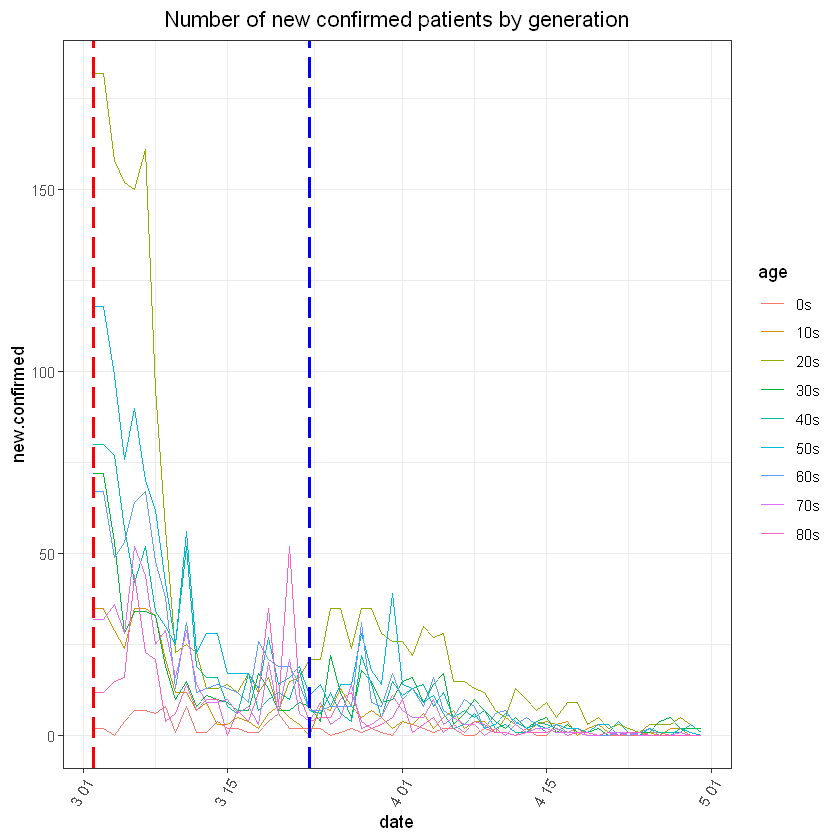

In [9]:
time_age.new %>% ggplot() + geom_line(aes(date,new.confirmed,colour=age,group=age)) +theme_bw()+ theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
  ggtitle("Number of new confirmed patients by generation") + theme(plot.title = element_text(hjust = 0.5)) +
  geom_vline(xintercept = as.Date("2020-03-23", "%Y-%m-%d"), linetype="longdash",  color = "blue", size=1)+
  geom_vline(xintercept = as.Date("2020-03-02", "%Y-%m-%d"), linetype="longdash",  color = "red", size=1)

일별 신규 확진자 분포를 연령별로 그룹화하여 그래프로 나타냈습니다.         
빨간색 선은 사회적 거리두기가 실시된 3월 2일, 파란색 선은 강화된 사회적 거리두기가 실시된 3월 22일을 뜻합니다.     
        
사회적 거리두기 실시 직후에 20대의 신규 확진자가 급격히 줄어 3월 중순에는 다른 연령대 확진자 수와 비슷한 분포를 보였습니다.      
하지만, 사회적 거리두기 기간이 장기화되면서 강화된 사회적 거리두기 실시 이후 20대의 확진자 수가 다시 늘어남을 확인할 수 있습니다.

왜 이런 현상이 나타날까요? 저희는 아래 가설들을 통해 그 이유를 파악해보고자 했습니다.

# 2. 20대 확진자 수가 많은 이유에 대한 가설 두 가지

## 2-1. 가설 1) 신규 확진자의 대부분을 차지하는 해외유입자 중 20대의 비율이 가장 크기 때문이다. 

#### overseas inflow 연령별 분포

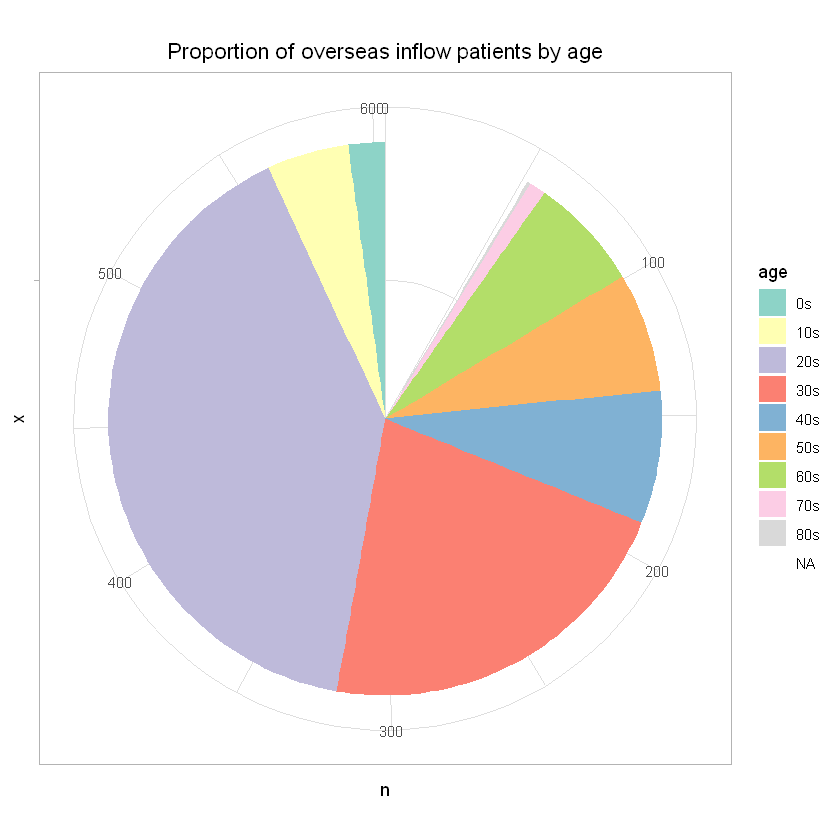

In [10]:
patient_info %>% filter(infection_case=="overseas inflow") %>% group_by(age) %>%
  summarise(n=n()) %>%
  ggplot(aes(x="", y=n, fill=age))+geom_bar(stat="identity")+
  coord_polar("y")+theme_light()+scale_fill_brewer(palette = "Set3")+
  ggtitle("Proportion of overseas inflow patients by age")+ theme(plot.title=element_text(hjust=0.5))

해외유입으로 감염된 확진자 중 각 연령대가 차지하는 비율을 pie chart로 나타냈습니다.     
예상대로, 20대가 해외유입 확진자의 절반 가까이를 차지하고 있습니다.

#### 해외유입 확진자의 방문장소: 20대 vs 50대 비교

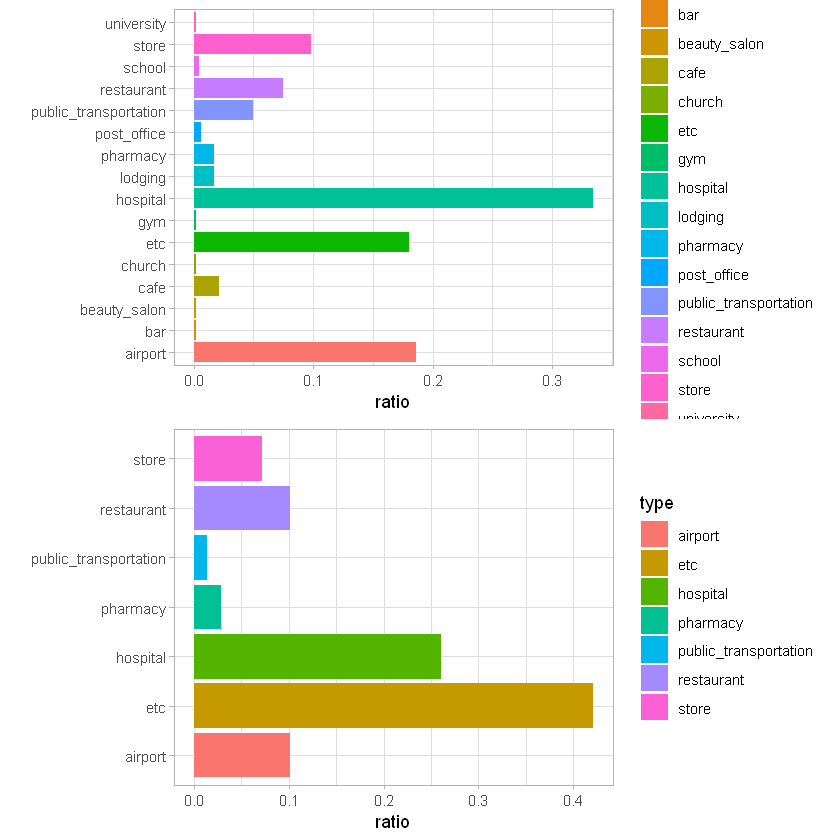

In [37]:
oversea <- patient_info %>% filter(infection_case=="overseas inflow" & age!="")
oversea_20_id <- filter(oversea,age %in% c("20s"))
oversea_20_id <- as.vector(oversea_20_id$patient_id)

oversea_20_route <- patient_route %>% filter(patient_id %in% oversea_20_id)
o20 <- oversea_20_route %>% ggplot() + geom_bar(aes(type,fill=type)) + coord_flip() + theme_light()

oversea_50_id <- filter(oversea,age %in% c("50s"))
oversea_50_id <- as.vector(oversea_50_id$patient_id)

oversea_50_route <- patient_route %>% filter(patient_id %in% oversea_50_id)
o50 <- oversea_50_route %>% ggplot() + geom_bar(aes(type,fill=type)) + coord_flip() + theme_light()

op50 <- oversea_50_route %>% group_by(type) %>% summarise(n=n()) %>% ungroup %>% ggplot() + 
        geom_bar(aes(x=type,y=n/sum(n),fill=type),stat="identity") + 
        coord_flip() + theme_light() + labs(x="", y="ratio")
op20 <- oversea_20_route %>% group_by(type) %>% summarise(n=n()) %>% ungroup %>% ggplot() + 
        geom_bar(aes(x=type,y=n/sum(n),fill=type),stat="identity") + 
        coord_flip() + theme_light() + labs(x="", y="ratio")

grid.arrange(op20,op50, nrow=2)

20대와 50대의 해외유입확진자들이 방문한 장소들과 횟수를 나타내었습니다.       
이때, 20대 해외유입 확진자수가 50대보다 많기 때문에, 단순히 방문횟수의 합이 아닌 전체 방문횟수에 대한 각 장소방문횟수를 비율로 나타내었습니다.   
    
그래프에서 Y축만 봐도 알 수 있듯이, 20대 해외유입 확진자는 50대에 비해 훨씬 다양한 종류의 장소에 방문한 것을 알 수 있습니다.    
또한 20대 해외유입 확진자는 카페, 체육관, 미용실 등 생활에 필수적이지 않은 장소에도 상대적으로 많이 방문했습니다.


#### 20대 확진자의 감염케이스 확인

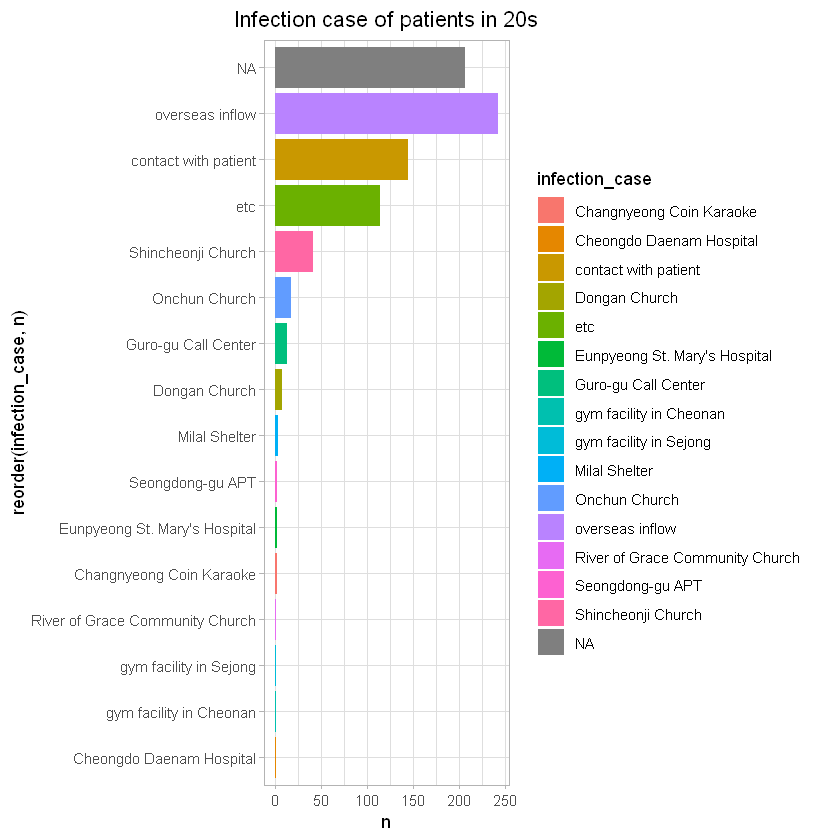

In [11]:
patient_info %>% filter(age=='20s') %>% group_by(infection_case) %>% summarise(n=n()) %>%
  ggplot(aes(reorder(infection_case, n), n, fill=infection_case)) + geom_bar(stat="identity")+coord_flip()+theme_light()+
  ggtitle("Infection case of patients in 20s") + 
  theme(plot.title=element_text(hjust=0.5)) + labs(x="")

전체 20대 확진자들의 감염경로를 보았을 때도, 역시나 해외유입으로 인한 케이스가 가장 많았습니다. 

하지만 '감염자와의 접촉'과 '기타 감염경로'를 통한 감염자 또한 적지 않은 수로 나타나 해외유입 이외의 감염경로에도 주목해야 할 것으로 보입니다.

#### 결론적으로 20대 해외유입 확진자의 다양한 장소방문이 코로나 확산의 원인이 될 수 있으나, 20대 해외유입 확진자 수의 절대적 증가만으로 20대 확진자 수가 늘어난 이유를 모두 설명할 수 없습니다.

## 2-2. 가설 2) 20대의 경각심이 하락했기 때문이다

그렇다면 단순히 '해외유입자'가 많은 것만이 최근 20대 확진자 증가 경향의 원인이 된다고 말할 수 있을까요?   
저희는 두 번째 가설로 20대의 '코로나 바이러스에 대한 경각심 부족'을 세워 분석해보았습니다.

### 2-2-1. 20대가 코로나에 대한 관심이 떨어져서 확진자가 증가하는 것이다.

#### 코로나에 대한 20대의 경각심이 사라지고 있음을 보여주는 기사
[코로나19 확진자 최다 연령대는 20대…사회적 거리두기 참여율은 낮아](http://www.busan.com/view/busan/view.php?code=2020041012515760588)       
    
위 기사에 따르면,    
최근 서울대학교 보건대학원 유명순 교수팀이 한국리서치에 의뢰하여 3월 25일~27일 ‘코로나 19 국민인식’ 설문조사를 시행한 결과    
20대가 외출자제, 대중교통 자제 비율이 전 연령대에서 가장 낮고, 사회적 거리두기 참여율도 가장 저조한 것으로 나타났습니다.


#### 네이버 데이터랩 데이터 이용 (~4/30)

이제 저희 팀은 네이버 데이터랩의 날짜별 검색량 추이를 통해 20대의 코로나에 대한 관심도를 확인해 보기로 하였습니다.     
         
살펴본 검색어는 크게 3가지 부류로, ‘코로나’(연관검색어 : 코로나바이러스,코로나19,확진자,우한,코로나증상,선별진료소), ‘공적마스크’(연관검색어:약국,마스크,공적마스크준비물,대리수령,kf94,면마스크), ‘사회적 거리두기’(연관검색어 :사회적거리두기,휴원,휴교,대학교,재택근무,재택)이고,     
2019년 12월 1일부터 2020년 4월 30일까지 연령대별 검색량 추이를 살펴보았습니다.

In [41]:
#네이버 데이터 랩------------------------------- 
library(readxl)
datalab_60 <- read_excel("datalab_60+.xlsx",skip=7,col_names = c("date","코로나","날짜1","공적마스크","날짜2","사회적거리두기")) %>% select(-c(3,5)) %>% mutate(age=60) 
datalab_50 <- read_excel("datalab_50_59.xlsx",skip=7,col_names = c("date","코로나","날짜1","공적마스크","날짜2","사회적거리두기")) %>% select(-c(3,5)) %>% mutate(age=50) 
datalab_40 <- read_excel("datalab_40_49.xlsx",skip=7,col_names = c("date","코로나","날짜1","공적마스크","날짜2","사회적거리두기")) %>% select(-c(3,5)) %>% mutate(age=40) 
datalab_30 <- read_excel("datalab_30_39.xlsx",skip=7,col_names = c("date","코로나","날짜1","공적마스크","날짜2","사회적거리두기")) %>% select(-c(3,5)) %>% mutate(age=30) 
datalab_20 <- read_excel("datalab_19_29.xlsx",skip=7,col_names = c("date","코로나","날짜1","공적마스크","날짜2","사회적거리두기")) %>% select(-c(3,5)) %>% mutate(age=20) 
datalab <- rbind(datalab_20,datalab_30,datalab_40,datalab_50,datalab_60)
datalab$date <- as.Date(datalab$date)
datalab$`코로나` <- as.numeric(datalab$`코로나`)
datalab$`공적마스크` <- as.numeric(datalab$`공적마스크`)
datalab$`사회적거리두기` <- as.numeric(datalab$`사회적거리두기`)
datalab <- as.data.frame(datalab)
str(datalab)

'data.frame':	835 obs. of  5 variables:
 $ date          : Date, format: "2019-12-01" "2019-12-02" ...
 $ 코로나        : num  0.00368 0.00523 0.00384 0.00413 0.00523 0.00425 0.00618 0.00315 0.00335 0.00483 ...
 $ 공적마스크    : num  0.196 0.171 0.165 0.16 0.152 ...
 $ 사회적거리두기: num  0.0252 0.0346 0.034 0.0432 0.0338 ...
 $ age           : num  20 20 20 20 20 20 20 20 20 20 ...


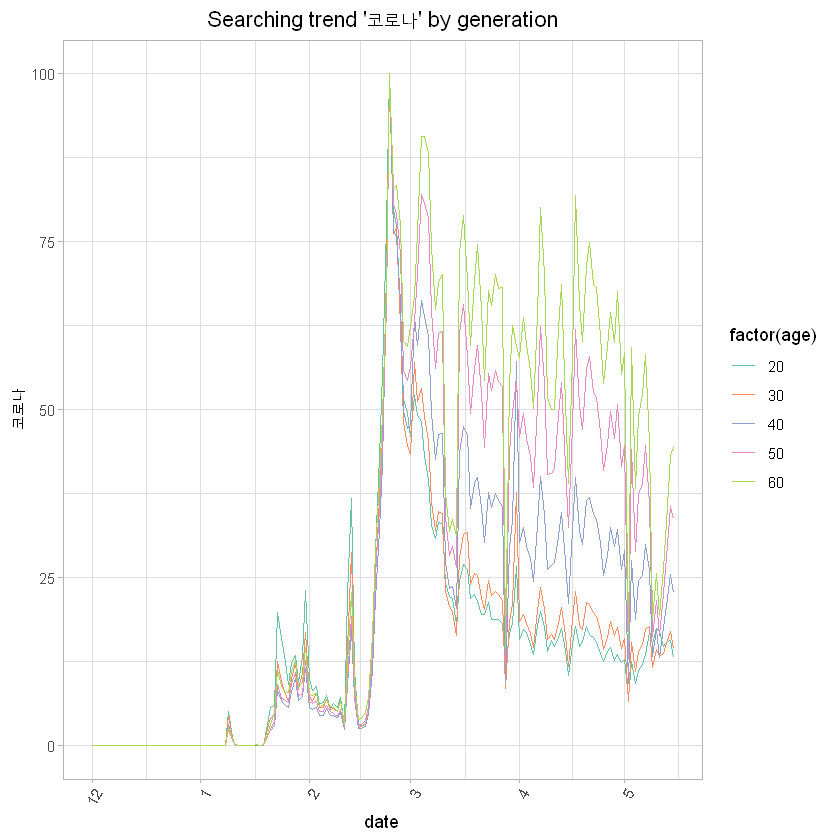

In [42]:
datalab %>% ggplot() + geom_line(aes(date,코로나, colour=factor(age))) +
theme_light()+ theme(axis.text.x = element_text(angle = 60, hjust = 1))+
  ggtitle("Searching trend '코로나' by generation") + 
theme(plot.title = element_text(hjust = 0.5))+scale_color_brewer(palette = "Set2")

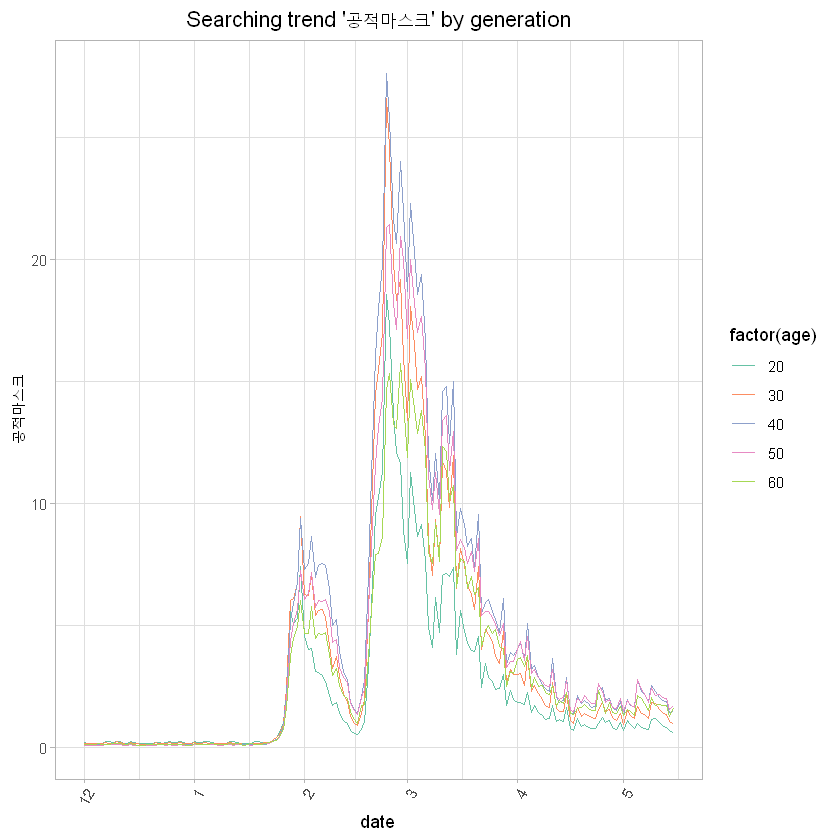

In [32]:
datalab %>% ggplot() + geom_line(aes(date,공적마스크, colour=factor(age))) +
theme_light()+ theme(axis.text.x = element_text(angle = 60, hjust = 1))+
  ggtitle("Searching trend '공적마스크' by generation") + 
theme(plot.title = element_text(hjust = 0.5))+scale_color_brewer(palette = "Set2")

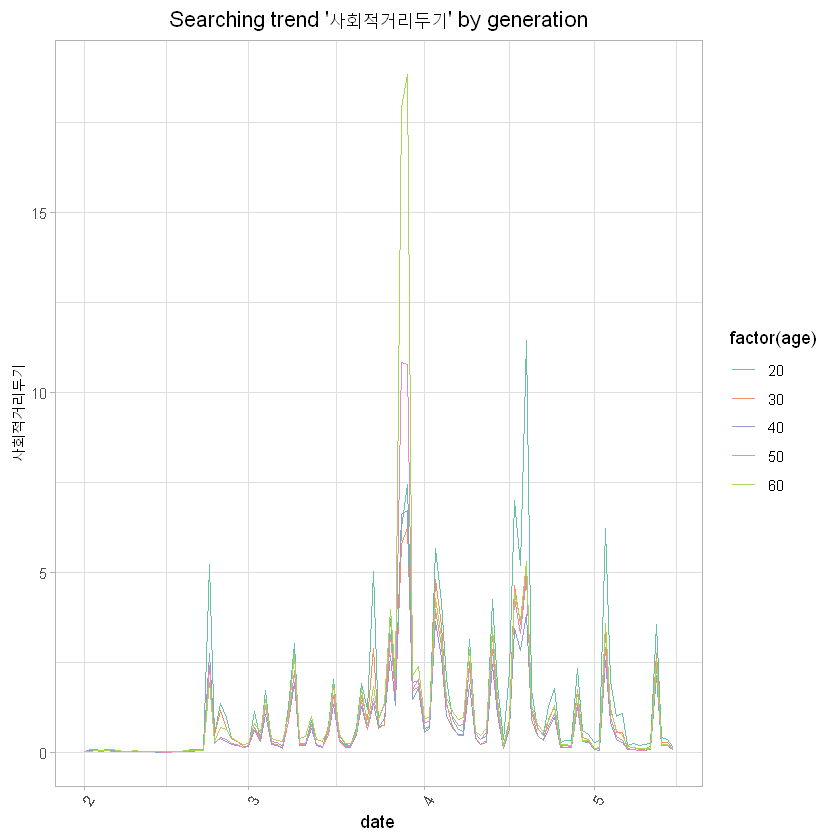

In [33]:
datalab %>% filter(date>='2020-02-01') %>% ggplot() + 
geom_line(aes(date,사회적거리두기, colour=factor(age))) +
theme_light()+ theme(axis.text.x = element_text(angle = 60, hjust = 1))+
  ggtitle("Searching trend '사회적거리두기' by generation") + 
theme(plot.title = element_text(hjust = 0.5))+scale_color_brewer(palette = "Set2")

위 세가지 그래프는 '코로나', '공적마스크', '사회적 거리두기'에 대한 검색량 횟수를 연령대별로 나타낸 것입니다.     
     
'코로나’와 ‘공적마스크’ 검색량의 경우 연령대별로 차이가 나는 것을 확인할 수 있었고, 그중 20대가 다른 연령대에 비해 검색량이 가장 적었습니다.     
'사회적 거리두기' 검색량의 경우, 사회적 거리두기가 처음 시행된 3월 2일에는 비교적 전 연령대가 비슷한 검색량을 보였습니다.     
강화한 사회적 거리두기가 시행된 3월 22일 이후에는 20대에 비해 고령층의 관심도가 눈에 띄게 많은 것을 확인할 수 있었습니다.     
         
20대가 50~60대에 비해 인터넷 접근성이 훨씬 높은 것을 고려한다면, 이 그래프들은 20대가 얼마나 코로나에 대한 관심이 떨어졌는지 보여줍니다. 

#### 연령대별 데이터랩 검색량과 확진자 수

그렇다면 코로나에 대한 검색량과 세대별 확진자수 추이는 어떤 관계가 있을까요?      
            
연령별, 날짜별 확진자 수 변화와 코로나에 대한 검색량 간의 관계를 알기 위해, time_age_new 데이터셋과 datalab 데이터셋을 join하였습니다.

In [34]:
time_age_new2 <- time_age.new
time_age_new2$age[which(time_age_new2$age=="0s")]<-"0"
time_age_new2$age[which(time_age_new2$age=="10s")]<-"10"
time_age_new2$age[which(time_age_new2$age=="20s")]<-"20"
time_age_new2$age[which(time_age_new2$age=="30s")]<-"30"
time_age_new2$age[which(time_age_new2$age=="40s")]<-"40"
time_age_new2$age[which(time_age_new2$age=="50s")]<-"50"
time_age_new2$age[which(time_age_new2$age=="60s")]<-"60"
time_age_new2$age[which(time_age_new2$age=="70s")]<-"70"
time_age_new2$age[which(time_age_new2$age=="80s")]<-"80"
time_age_new2$age <- as.numeric(time_age_new2$age)

datalab_confirmed <- inner_join(datalab,time_age_new2,by=c("date","age"))
head(datalab_confirmed)

,date,코로나,공적마스크,사회적거리두기,age,time,confirmed,deceased,new.confirmed
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020-03-02,52.12726,11.25593,1.14954,20,0,1235,0,182
2,2020-03-03,49.15244,9.73630,0.35587,20,0,1417,0,182
3,2020-03-04,48.28141,8.64493,1.72106,20,0,1575,0,158
4,2020-03-05,43.07672,9.13024,0.23901,20,0,1727,0,152
5,2020-03-06,39.55977,7.67967,0.20892,20,0,1877,0,150
6,2020-03-07,32.73103,4.93141,0.11248,20,0,2038,0,161


#### 연령별, 날짜별 확진자 수 변화와 코로나에 대한 검색량 간의 관계

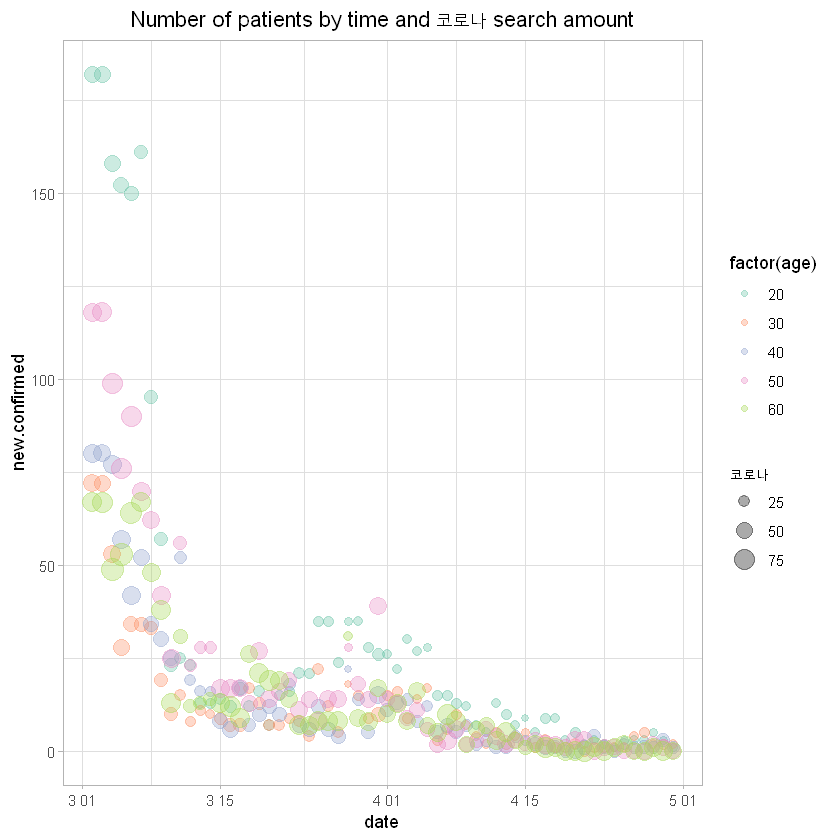

In [35]:
datalab_confirmed %>% ggplot(aes(date,new.confirmed)) + 
geom_point(aes(size=코로나,fill=factor(age),colour=factor(age)),alpha=1/3) +
  scale_size_area() + theme_light() + 
ggtitle("Number of patients by time and 코로나 search amount") + theme(plot.title = element_text(hjust = 0.5)) +
scale_color_brewer(palette="Set2")

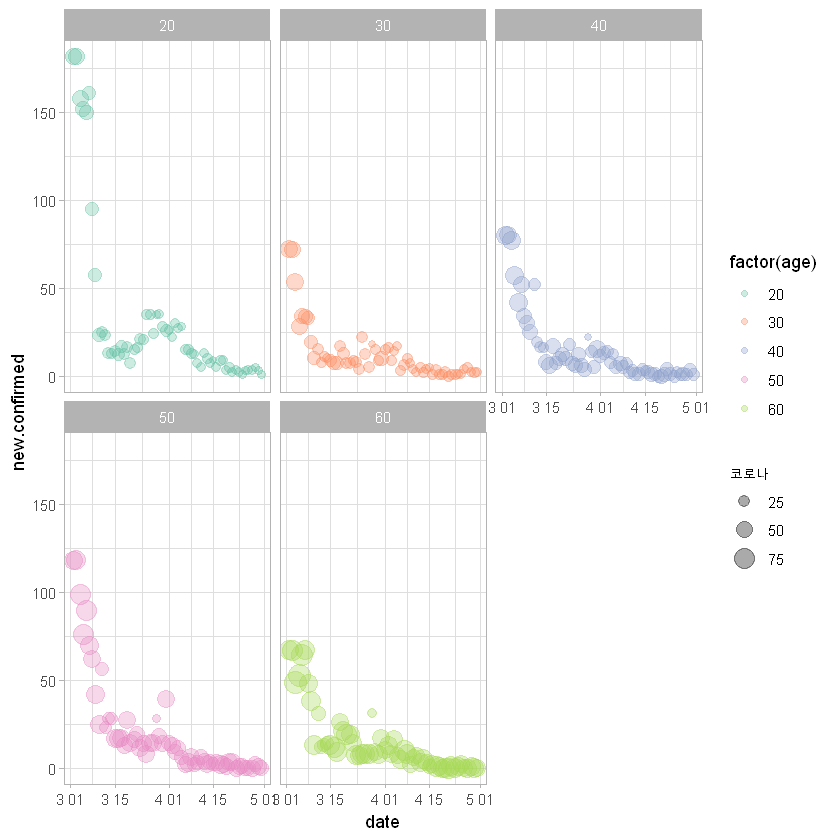

In [36]:
datalab_confirmed %>% ggplot(aes(date,new.confirmed)) + geom_point(aes(size=코로나,fill=factor(age),colour=factor(age)),alpha=1/3) +
  scale_size_area() + theme_light() + facet_wrap(~age) + scale_color_brewer(palette="Set2")


위 두 그래프들은 날짜별 신규 확진자 수를 나타내고 있으며, 여기서 색깔은 각 연령층을, 원의 크기는 코로나검색 빈도를 말합니다.    

20대(청록색)는 50대(분홍색)와 60대(연두색)에 비해 원의 크기, 즉 코로나 검색량이 작고 비교적 그 변동이 급격한것을 확인할 수 있습니다.    
    
따라서 코로나에 대한 관심도가 낮을수록 확진자수가 급변하며, 이는 20대의 코로나 관심도 하락이 확진자 수 증가와 관련이 있다는 주장을 뒷받침할 수 있습니다.

### 2-2-2. 20대의 코로나에 대한 관심도가 하락해서 외출이 증가했다.

이렇듯 코로나에 대한 낮은 관심도는 외출 증가로 이어지는 원인이 될 수 있습니다.     
아래 그래프는 확진자들의 방문장소 개수의 총합을 연령대별로 보여줍니다.

#### 연령대별 확진자 경로 수 총합

Joining, by = "patient_id"



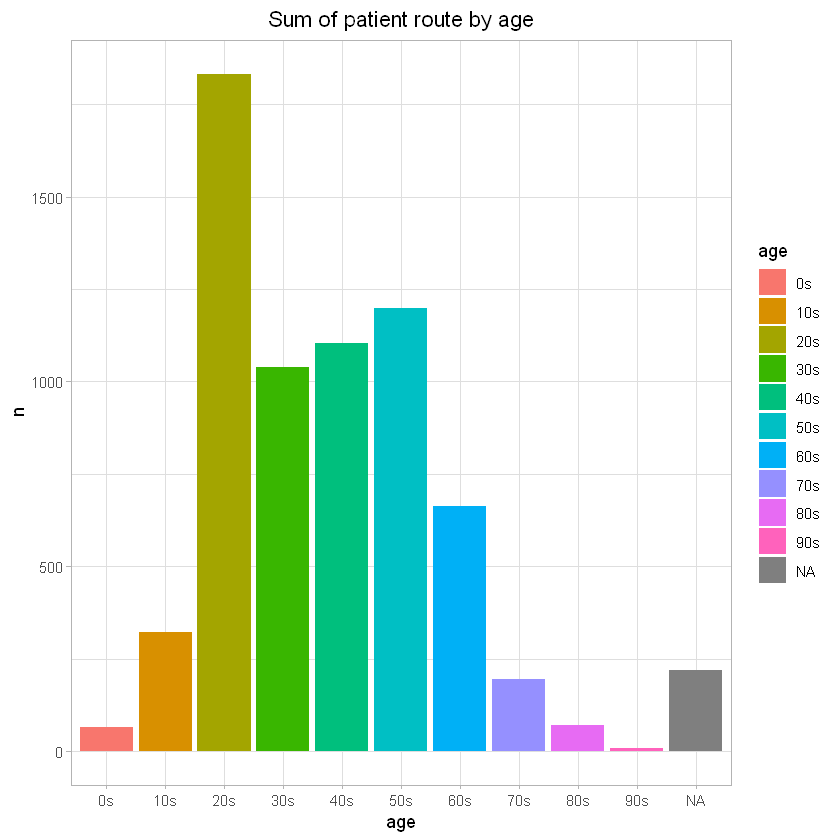

In [15]:
#patient_id를 key로 하여 patient_route와 patient_info의 age 변수를 join
patient_route <- patient_info %>% select(patient_id, age) %>% right_join(patient_route)

patient_route %>%group_by(age) %>% summarise(n=n()) %>%
  ggplot(aes(age, n, fill=age))+geom_bar(stat="identity")+
  theme_light()+ggtitle("Sum of patient route by age") +
  theme(plot.title=element_text(hjust=0.5))

20대 확진자들이 특정 장소에 방문한 횟수가 가장 많은 것을 확인할 수 있었습니다.    

그러나 이 그래프는 확진자 1인에 대한 방문 횟수가 아닌 해당 연령 전체 확진자에 대한 방문횟수의 총합이기 때문에, 최근 확진자가 늘어난 20대가 높은 값을 가지는 것이 어쩌면 당연할 수 있습니다.   
    
따라서 저희는 이동경로수가 가장 많은 상위 25%의 확진자들의 연령분포를 그려보았습니다. 

In [25]:
#확진자별 이동경로 수를 담은 route_num 데이터 생성
route_num <- patient_route %>% group_by(patient_id, global_num) %>% summarise(visit_num=n()) %>%left_join(patient_info)
head(route_num)

Joining, by = c("patient_id", "global_num")



patient_id,global_num,visit_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
<dbl>,<dbl>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<date>,<date>,<date>,<chr>
1e+09,2,2,male,1964,50s,Korea,Seoul,Gangseo-gu,NA,overseas inflow,1,NA,75,2020-01-22,2020-01-23,2020-02-05,NA,released
1e+09,5,13,male,1987,30s,Korea,Seoul,Jungnang-gu,NA,overseas inflow,1,NA,31,NA,2020-01-30,2020-03-02,NA,released
1e+09,6,2,male,1964,50s,Korea,Seoul,Jongno-gu,NA,contact with patient,2,2.002e+09,17,NA,2020-01-30,2020-02-19,NA,released
1e+09,7,1,male,1991,20s,Korea,Seoul,Mapo-gu,NA,overseas inflow,1,NA,9,2020-01-26,2020-01-30,2020-02-15,NA,released
1e+09,9,1,female,1992,20s,Korea,Seoul,Seongbuk-gu,NA,contact with patient,2,1.000e+09,2,NA,2020-01-31,2020-02-24,NA,released
1e+09,10,1,female,1966,50s,Korea,Seoul,Jongno-gu,NA,contact with patient,3,1.000e+09,43,NA,2020-01-31,2020-02-19,NA,released


#### 이동경로 수가 상위 25% 안에 드는 확진자의 연령분포 확인

In [44]:
quantile(route_num$visit_num)

0%  25%  50%  75% 100% 
   1    2    4    7   45

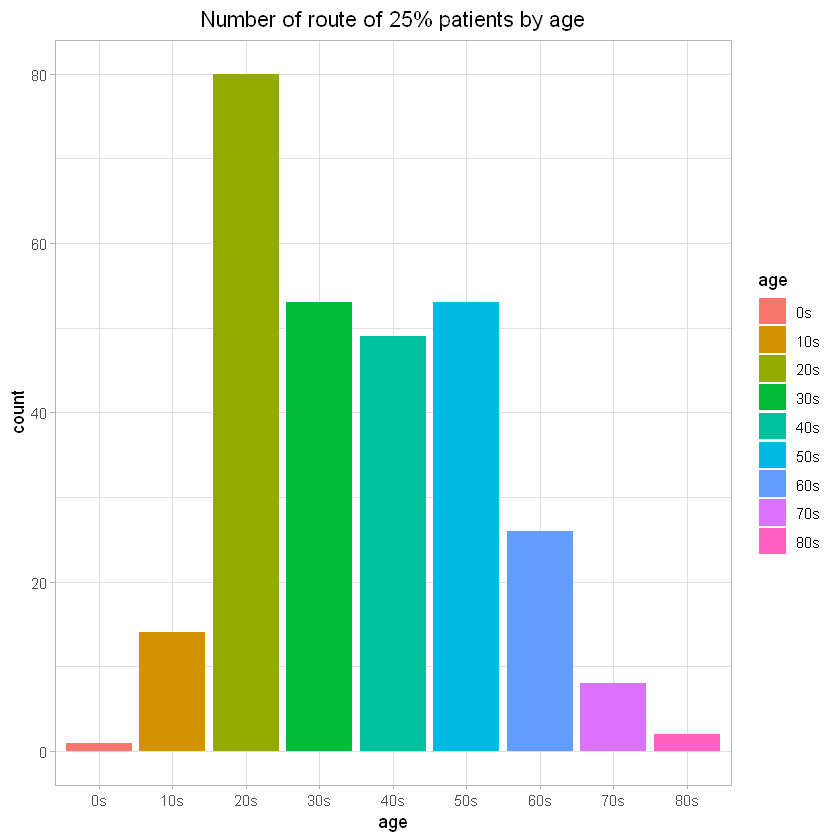

In [18]:
route_num %>% filter(visit_num>=8) %>% filter(is.na(age)==FALSE)%>% ggplot(aes(age,fill=age))+geom_bar()+theme_light()+
  ggtitle('Number of route of 25% patients by age')+
  theme(plot.title=element_text(hjust=0.5))

전체 확진자들 중 이동경로가 많은 상위 25%의 연령분포를 확인해보았을 때도, 20대가 가장 많았습니다. 

#### 확진자의 일별 평균 이동경로수를 연령대별로 비교

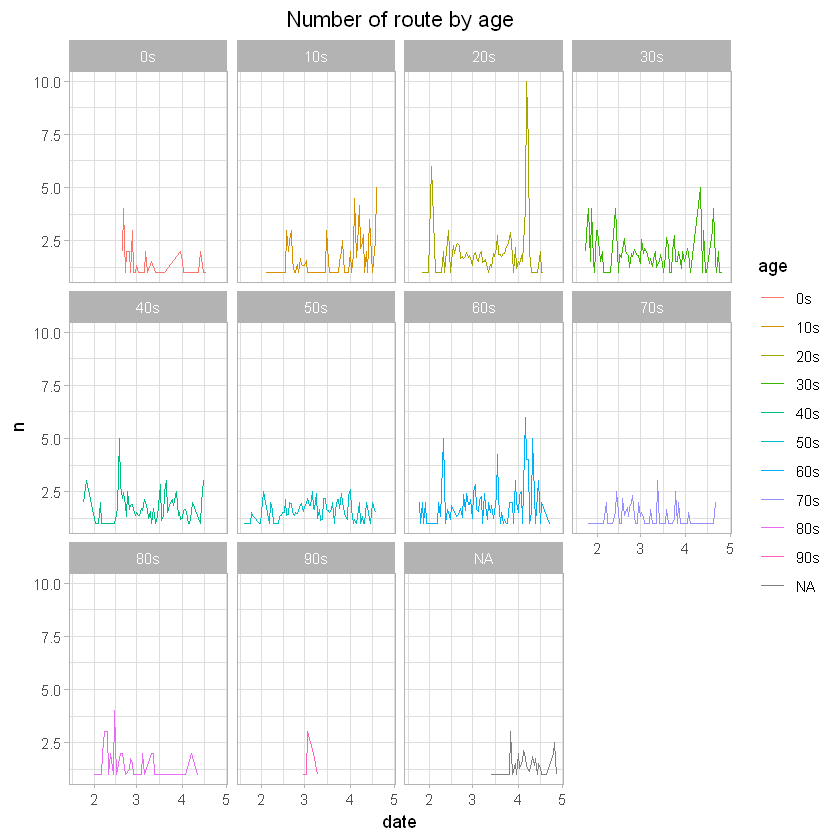

In [19]:
patient_route %>% group_by(patient_id, date, age) %>% summarise(n=n()) %>% group_by(age, date) %>% summarise(n=mean(n))%>%
  ggplot(aes(date, n, colour=age))+geom_line()+facet_wrap(~age)+theme_light()+
  ggtitle('Number of route by age') + theme(plot.title = element_text(hjust=0.5))

확진자의 일별 평균 이동경로수를 연령대별로 비교한 결과입니다. 각 그래프의 가로축은 날짜를 나타냅니다.    
20대 확진자들의 이동경로수의 평균이 꾸준히 높고 특히나 4월 초쯤 이동경로수가 폭발적으로 증가한 것을 볼 수 있습니다.

### 2-2-3. 증상이 시작된 날부터 확진받기까지의 기간이 20대의 경우 늘었을 것이다.

의심 증상이 보였음에도 불구하고 검사를 받지 않고 바이러스를 전파시키는 사례가 심심치 않게 나타나 많은 국민의 질타를 받는 사건들이 있었습니다.      
     
저희는 20대가 코로나에 대한 경각심이 떨어져 증상이 나타났음에도 불구하고 검사를 받지않고 무시하고 생활하다가 뒤늦게 확진 판정을 받았을 가능성이 높다고 생각했습니다.     
                
이에 강화된 사회적 거리두기를 실시한 3월 22일께를 전후로, ‘증상이 시작된 날부터 확진받기까지의 기간’을 살펴보기로 했습니다.  

####  patient_info 증상이 시작한 날로부터 확진날 까지의 기간
앞서 확인한 대로, 20대는 강화된 사회적 거리두기 이후에도 확진자 수가 가장 많이 증가하는 추세를 보였었는데요.   

아래의 두 그래프를 통해, 3월 20일 전에는 20대의 확진까지의 기간이 오히려 짧고 60, 70대가 더 길지만, 3월 21일 이후에는 10, 20대가 확실히 확진까지의 기간이 더 오래걸리는 것을 확인할 수 있습니다.

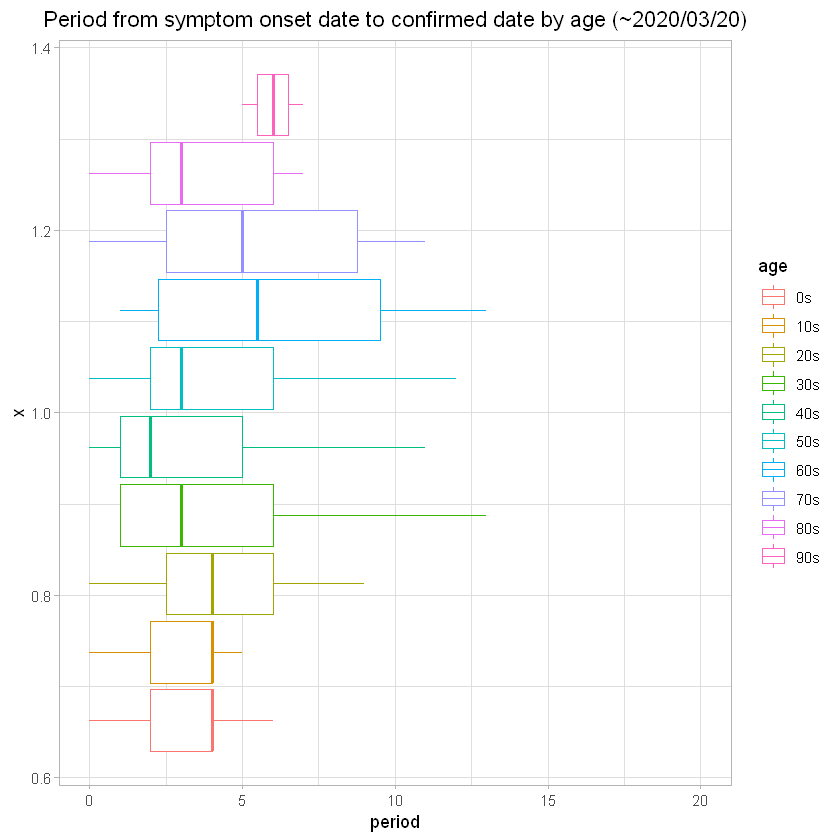

In [20]:
# ~ 03/20
patient_info %>% 
  mutate(to_confirm=as.numeric(difftime(confirmed_date,symptom_onset_date), units="days")) %>%
  filter(!is.na(to_confirm) & !is.na(age) & infection_case %in% c("contact with patient", "etc", NA) & 
           confirmed_date <= '2020-03-20') %>% group_by(age) %>% 
  ggplot(aes(1, to_confirm, colour=age)) + geom_boxplot() + coord_flip() + ylim(c(0, 20)) +
  theme_light()+ggtitle('Period from symptom onset date to confirmed date by age (~2020/03/20)') + 
  labs(y = "period") + theme(plot.title = element_text(hjust=0.5)) 
options(warn=-1)

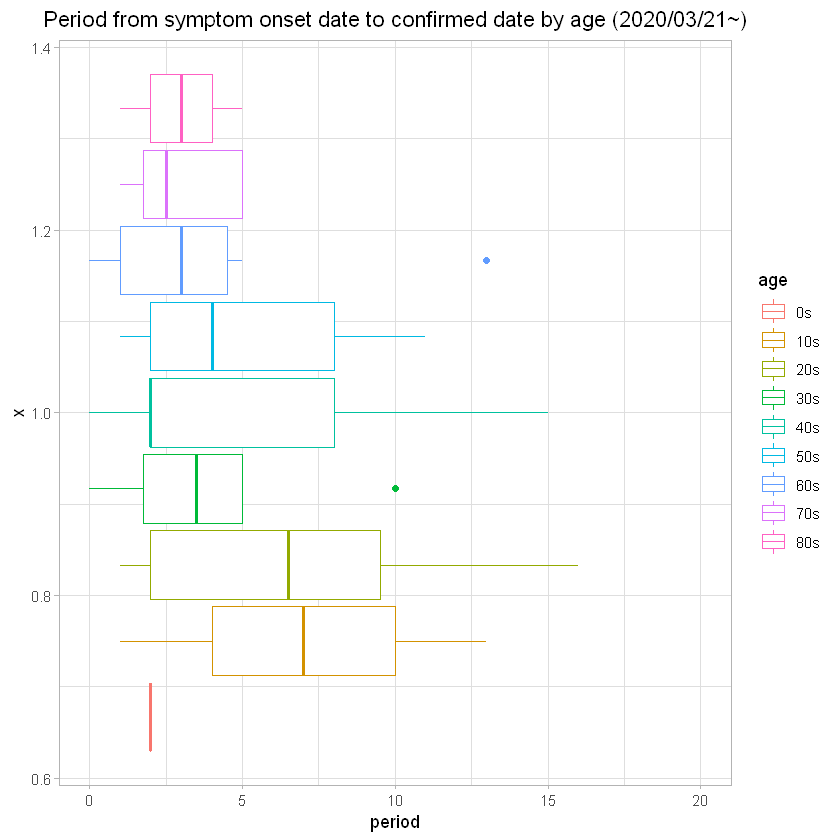

In [21]:
# 03/21 ~ 
patient_info %>% 
  mutate(to_confirm=as.numeric(difftime(confirmed_date,symptom_onset_date), units="days")) %>%
  filter(!is.na(to_confirm) & !is.na(age) & infection_case %in% c("contact with patient", "etc", NA) & 
           confirmed_date > '2020-03-20') %>% group_by(age) %>% 
  ggplot(aes(1, to_confirm, colour=age)) + geom_boxplot() + coord_flip() + ylim(c(0, 20)) +
  theme_light()+ggtitle('Period from symptom onset date to confirmed date by age (2020/03/21~)') + 
  labs(y = "period") + theme(plot.title = element_text(hjust=0.5)) 
options(warn=-1)

즉 최근 들어 10~20대의 코로나에 대한 경각심이 줄어들어서, 의심 증상이 시작되고 나서도 검사를 받지 않고 계속해서 돌아다녔다는 것입니다.     

#### 위의 그래프들을 종합적으로 봤을 때, 경각심을 잃은 20대가 코로나 전파에 큰 위험이 된다는 것을 알 수 있습니다.

# 3. 20대도 조심해야 하는 이유 
##  : 20대의 면역력에 대한 그릇된 자부심

[마스크 없이 콜록콜록···강남클럽 앞 20대 "난 코로나 안 걸려"](https://n.news.naver.com/article/025/0002985881?ntype=RANKING)    
    
“에이 나는 젊어서 안 걸려~”, “걸려도 20대는 괜찮대”   
혹시 이 글을 읽고 있는 20대 여러분들, 친구들이 이런말을 자주 하지 않던가요?    
최근 술집과 클럽에 새벽까지 줄을 서는 상황에 대한 문제의식이 커지고 있습니다.    
서울시는 지난 8일 유흥업소에 대한 영업중지 명령을 내리기까지 했습니다.    
     
과연 20대는 정말로 면역력이 강해 코로나에 대한 저항성이 강할까요?    
저희는 격리해제자의 데이터를 담은 released 데이터를 생성하여, 연령별 치료기간 분포를 확인해 보았습니다. 

In [22]:
# 격리해제자의 데이터를 담은 released 데이터 생성
released <- patient_info %>% filter(state=="released")
head(released)

patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<date>,<date>,<date>,<chr>
1e+09,2,male,1964,50s,Korea,Seoul,Gangseo-gu,NA,overseas inflow,1,NA,75,2020-01-22,2020-01-23,2020-02-05,NA,released
1e+09,5,male,1987,30s,Korea,Seoul,Jungnang-gu,NA,overseas inflow,1,NA,31,NA,2020-01-30,2020-03-02,NA,released
1e+09,6,male,1964,50s,Korea,Seoul,Jongno-gu,NA,contact with patient,2,2.002e+09,17,NA,2020-01-30,2020-02-19,NA,released
1e+09,7,male,1991,20s,Korea,Seoul,Mapo-gu,NA,overseas inflow,1,NA,9,2020-01-26,2020-01-30,2020-02-15,NA,released
1e+09,9,female,1992,20s,Korea,Seoul,Seongbuk-gu,NA,contact with patient,2,1.000e+09,2,NA,2020-01-31,2020-02-24,NA,released
1e+09,10,female,1966,50s,Korea,Seoul,Jongno-gu,NA,contact with patient,3,1.000e+09,43,NA,2020-01-31,2020-02-19,NA,released


#### 연령별 치료기간 분포

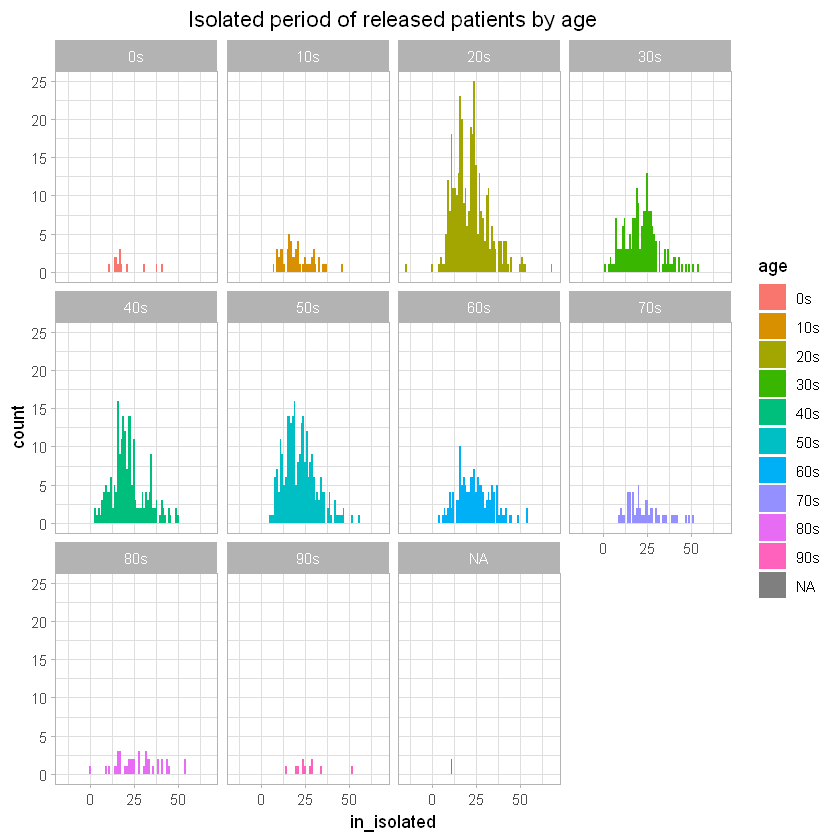

In [23]:
released <- released %>% mutate(in_isolated=as.numeric(difftime(released$released_date, released$confirmed_date), units="days"))
released %>% ggplot(aes(in_isolated, fill=age))+geom_histogram(binwidth=1) + 
theme_light() + ggtitle("Isolated period of released patients by age") + 
facet_wrap(~age)+ theme(plot.title = element_text(hjust=0.5)) 

확진자들의 연령대별 치료기간에 대한 히스토그램입니다.     
이때 치료기간은 확진받은 날부터 격리 해제될 때 까지의 기간을 말합니다.      
         
위 그래프에서 볼 수 있듯이, 20대라고 해서 다른 고령층의 치료기간과 별반 다르지 않았습니다.   
즉 확진받은 후 격리해제를 받기까지 걸리는 시간은 연령별로 별다른 차이가 없었습니다. 

#### 기저질환이 없는 확진자의 완치비율

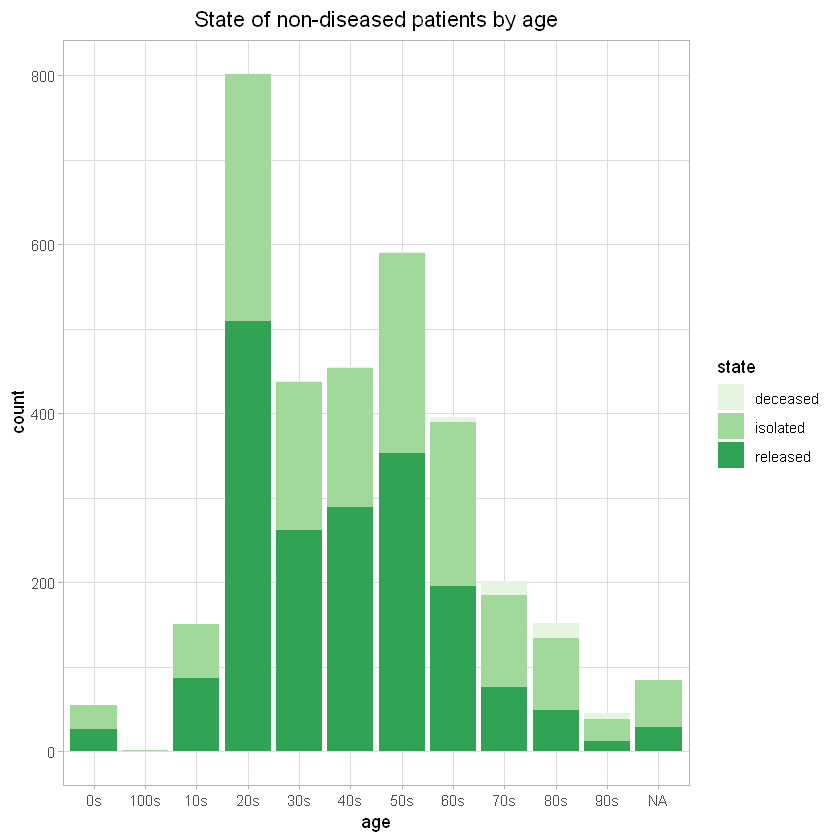

In [40]:
patient_info %>% filter(is.na(disease)==TRUE) %>% 
ggplot(aes(age, fill=state))+geom_bar()+theme_light()+
ggtitle("State of non-diseased patients by age")+ 
theme(plot.title = element_text(hjust=0.5)) + scale_fill_brewer(palette = "Greens")

기저질환이 없는 확진자들의 연령대별 완치비율을 그래프로 나타냈습니다. 진한 초록색은 격리해제, 즉 완치된 환자의 수를 나타냅니다.    
기저질환이 없는 확진자들의 완치 비율도 20대와 다른 연령대 간에 차이가 없는 것을 확인할 수 있습니다.   

# 4. 결론


4월 말까지의 데이터에 따르면 코로나 바이러스가 점차 하락세에 접어들긴 했지만,    
다른 연령대의 경향과 다르게 20대의 경우 꾸준히 적지 않은 수의 신규 확진자가 발생하고 있었습니다.      
당시 해외 유입자가 급격히 증가하였고 그들 중 20대가 많다는 것이 이 사실의 원인이 될 수 있으나,     
해외 유입자 중에서도 특히 20대가 여러 장소에 방문하는 등 다른 연령대에 비해 경각심이 낮은 모습을 보였습니다.      
        
즉, 그 무엇보다 심각한 이유는 20대의 코로나에 대한 경각심 하락입니다.     
20대는 신천지 집단 감염 직후에 코로나에 대해 많은 관심을 보이고 사회적 거리두기에도 적절히 참여하였지만,       
사회적 거리두기 기간이 점차 길어짐에 따라 관심도가 하락하여 점차 외출 빈도가 다른 연령대에 비해 크게 증가하였습니다.      
또한 본인들의 젊음과 면역력을 과도하게 믿고 증상 발현 후 검사까지의 기간도 길게 나타났습니다.      
              
              
불과 한 달 전까지만 해도 안정권에 접어들었던 코로나 바이러스 경향이 최근 이태원 클럽발 코로나 바이러스 집단 감염 사례로 완전히 뒤바뀌었습니다.      
이러한 사건의 가장 크고 근본적인 원인은 저희 팀이 지금까지 살펴보았던 20대의 안일한 생각과 태도입니다.     
         
20대의 태도가 바뀌지 않는다면 국내 코로나 바이러스는 결코 종식될 수 없을 것입니다.    
즉, 20대의 그릇된 믿음과는 달리 그들 또한 코로나에 특별히 강하지 않으며 이들이 국내 코로나 바이러스 감염증의 확산에 핵심적인 역할을 하고 있기 때문에        
정부 차원에서의 20대에 대한 특별한 관심이 필요할 뿐만 아니라, 20대 스스로도 경각심을 더욱 일깨워야 할 것입니다.      
